In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
from tqdm import tqdm
from scipy.signal import resample
from keras.layers import *
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.backend import expand_dims
from sklearn.preprocessing import StandardScaler
import tensorflow as tf


#from keras.models import Model
#from keras.layers import Input, Dense, LSTM, multiply, concatenate, Activation, Masking, Reshape
#from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D, Permute, Dropout

from utils.constants import MAX_NB_VARIABLES, NB_CLASSES_LIST, MAX_TIMESTEPS_LIST
from utils.keras_utils import train_model, evaluate_model, set_trainable
#from utils.layer_utils import AttentionLSTM
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import math

%matplotlib inline
%matplotlib inline

In [2]:
def acc_combo(y, y_pred):
    # 数值ID与行为编码的对应关系
    mapping = {0: 'A_0', 1: 'A_1', 2: 'A_2', 3: 'A_3', 
        4: 'D_4', 5: 'A_5', 6: 'B_1',7: 'B_5', 
        8: 'B_2', 9: 'B_3', 10: 'B_0', 11: 'A_6', 
        12: 'C_1', 13: 'C_3', 14: 'C_0', 15: 'B_6', 
        16: 'C_2', 17: 'C_5', 18: 'C_6'}
    # 将行为ID转为编码
    code_y, code_y_pred = mapping[y], mapping[y_pred]
    if code_y == code_y_pred: #编码完全相同得分1.0
        return 1.0
    elif code_y.split("_")[0] == code_y_pred.split("_")[0]: #编码仅字母部分相同得分1.0/7
        return 1.0/7
    elif code_y.split("_")[1] == code_y_pred.split("_")[1]: #编码仅数字部分相同得分1.0/3
        return 1.0/3
    else:
        return 0.0

train = pd.read_csv('sensor_train.csv')
test = pd.read_csv('sensor_test.csv')
#train_fly = pd.read_csv('train_fly.csv')
#test_fly = pd.read_csv('test_fly.csv')
sub = pd.read_csv('sub.csv')
y = train.groupby('fragment_id')['behavior_id'].min()

train['mod'] = (train.acc_x ** 2 + train.acc_y ** 2 + train.acc_z ** 2) ** .5
train['modg'] = (train.acc_xg ** 2 + train.acc_yg ** 2 + train.acc_zg ** 2) ** .5
train['xy'] = (train.acc_x ** 2 + train.acc_y ** 2) ** .5
train['xy_g'] = (train.acc_xg ** 2 + train.acc_yg ** 2) ** .5
test['mod'] = (test.acc_x ** 2 + test.acc_y ** 2 + test.acc_z ** 2) ** .5
test['modg'] = (test.acc_xg ** 2 + test.acc_yg ** 2 + test.acc_zg ** 2) ** .5
test['xy'] = (test.acc_x ** 2 + test.acc_y ** 2) ** .5
test['xy_g'] = (test.acc_xg ** 2 + test.acc_yg ** 2) ** .5

#origin_fea_cols = ['acc_x','acc_y','acc_z','acc_xg','acc_yg','acc_zg','mod','modg','xy','xy_g']
#train_xyz_fea1 = get_1st_order_xyz_features(train,origin_fea_cols,main_col='fragment_id')
#test_xyz_fea1 = get_1st_order_xyz_features(test,origin_fea_cols,main_col='fragment_id')

#train = train.merge(train_xyz_fea1,how='left',on='fragment_id')
#test = test.merge(test_xyz_fea1,how='left',on='fragment_id')
feature_cols = [col for col in train.columns if col not in ['fragment_id','time_point','behavior_id']]
std_scaler = StandardScaler()
train[feature_cols] = std_scaler.fit_transform(train[feature_cols])
test[feature_cols] = std_scaler.transform(test[feature_cols])

feauture_len = len(feature_cols)

x = np.zeros((7292, 60, feauture_len, 1))
t = np.zeros((7500, 60, feauture_len, 1))
for i in tqdm(range(7292)):
    tmp = train[train.fragment_id == i][:60]
    x[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point', 'behavior_id'],
                                    axis=1), 60, np.array(tmp.time_point))[0]
for i in tqdm(range(7500)):
    tmp = test[test.fragment_id == i][:60]
    t[i,:,:, 0] = resample(tmp.drop(['fragment_id', 'time_point'],
                                    axis=1), 60, np.array(tmp.time_point))[0]  

100%|█████████████████████████████████████████████████████████████████████████████| 7500/7500 [00:09<00:00, 753.34it/s]


In [3]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, n_layers):
        super(Model, self).__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size
        self.n_layers = n_layers
        #self.fc0 = nn.Linear(input_size,hidden_size)
        self.gru = nn.GRU(input_size,hidden_size,batch_first=True,bidirectional=False)
        
        #self.fc1 = nn.Linear(hidden_size,64)
        #self.fc2 = nn.Linear(64,3)
        self.fc = nn.Linear(hidden_size,output_size)
        

    
    def forward(self,x):
        
        batch_size = x.size(0)

        # Initializing hidden state for first input using method defined below
        hidden,cell = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        output,hidden = self.gru(x,hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        output = output.contiguous()[:,-1,:]
        #[:,-1, self.hidden_size].squeeze(1)

        output = self.fc(output)
        
        
        return output, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        # We'll send the tensor holding the hidden state to the device we specified earlier as well
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size,device=device)
        return hidden,hidden

In [23]:
# Instantiate the model with hyperparameters
input_size = 10 
output_size = 19
model = Model(input_size=input_size, output_size=output_size, hidden_size=16, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)

# Define hyperparameters
n_epochs = 8000
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [5]:
x_ = torch.tensor(x).squeeze(-1)
y_ = torch.tensor(y)
x_ = x_.to(device)
y_ = y_.to(device)

In [24]:
# Training Run

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad() # Clears existing gradients from previous epoch

    output, hidden = model(x_.float())
    loss = criterion(output, y_)
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/8000............. Loss: 2.5981
Epoch: 20/8000............. Loss: 2.1904
Epoch: 30/8000............. Loss: 1.9910
Epoch: 40/8000............. Loss: 1.8642
Epoch: 50/8000............. Loss: 1.7618
Epoch: 60/8000............. Loss: 1.6839
Epoch: 70/8000............. Loss: 1.6248
Epoch: 80/8000............. Loss: 1.5855
Epoch: 90/8000............. Loss: 1.5420
Epoch: 100/8000............. Loss: 1.5133
Epoch: 110/8000............. Loss: 1.4808
Epoch: 120/8000............. Loss: 1.4614
Epoch: 130/8000............. Loss: 1.4355
Epoch: 140/8000............. Loss: 1.4095
Epoch: 150/8000............. Loss: 1.3986
Epoch: 160/8000............. Loss: 1.3749
Epoch: 170/8000............. Loss: 1.3556
Epoch: 180/8000............. Loss: 1.3493
Epoch: 190/8000............. Loss: 1.3232
Epoch: 200/8000............. Loss: 1.3122
Epoch: 210/8000............. Loss: 1.2976
Epoch: 220/8000............. Loss: 1.2894
Epoch: 230/8000............. Loss: 1.2784
Epoch: 240/8000............. Loss: 1.2734
E

Epoch: 1950/8000............. Loss: 1.2217
Epoch: 1960/8000............. Loss: 1.1582
Epoch: 1970/8000............. Loss: 1.0791
Epoch: 1980/8000............. Loss: 1.0935
Epoch: 1990/8000............. Loss: 1.0513
Epoch: 2000/8000............. Loss: 1.0249
Epoch: 2010/8000............. Loss: 1.0104
Epoch: 2020/8000............. Loss: 0.9960
Epoch: 2030/8000............. Loss: 0.9939
Epoch: 2040/8000............. Loss: 1.0031
Epoch: 2050/8000............. Loss: 0.9906
Epoch: 2060/8000............. Loss: 0.9807
Epoch: 2070/8000............. Loss: 0.9911
Epoch: 2080/8000............. Loss: 1.1465
Epoch: 2090/8000............. Loss: 1.0850
Epoch: 2100/8000............. Loss: 1.0437
Epoch: 2110/8000............. Loss: 1.0142
Epoch: 2120/8000............. Loss: 0.9975
Epoch: 2130/8000............. Loss: 0.9881
Epoch: 2140/8000............. Loss: 0.9825
Epoch: 2150/8000............. Loss: 0.9777
Epoch: 2160/8000............. Loss: 1.0113
Epoch: 2170/8000............. Loss: 1.0573
Epoch: 2180

Epoch: 3860/8000............. Loss: 0.8599
Epoch: 3870/8000............. Loss: 0.8483
Epoch: 3880/8000............. Loss: 0.8405
Epoch: 3890/8000............. Loss: 0.8465
Epoch: 3900/8000............. Loss: 1.0489
Epoch: 3910/8000............. Loss: 1.0308
Epoch: 3920/8000............. Loss: 0.9611
Epoch: 3930/8000............. Loss: 0.9373
Epoch: 3940/8000............. Loss: 0.9419
Epoch: 3950/8000............. Loss: 0.9386
Epoch: 3960/8000............. Loss: 0.9101
Epoch: 3970/8000............. Loss: 0.8837
Epoch: 3980/8000............. Loss: 0.8729
Epoch: 3990/8000............. Loss: 0.9069
Epoch: 4000/8000............. Loss: 0.8965
Epoch: 4010/8000............. Loss: 0.8717
Epoch: 4020/8000............. Loss: 0.8995
Epoch: 4030/8000............. Loss: 1.0099
Epoch: 4040/8000............. Loss: 0.9466
Epoch: 4050/8000............. Loss: 0.9236
Epoch: 4060/8000............. Loss: 0.9036
Epoch: 4070/8000............. Loss: 0.9003
Epoch: 4080/8000............. Loss: 0.8883
Epoch: 4090

Epoch: 5770/8000............. Loss: 0.9797
Epoch: 5780/8000............. Loss: 0.9752
Epoch: 5790/8000............. Loss: 0.9772
Epoch: 5800/8000............. Loss: 0.9774
Epoch: 5810/8000............. Loss: 0.9773
Epoch: 5820/8000............. Loss: 0.9771
Epoch: 5830/8000............. Loss: 0.9701
Epoch: 5840/8000............. Loss: 0.9680
Epoch: 5850/8000............. Loss: 0.9728
Epoch: 5860/8000............. Loss: 0.9670
Epoch: 5870/8000............. Loss: 0.9645
Epoch: 5880/8000............. Loss: 0.9657
Epoch: 5890/8000............. Loss: 0.9629
Epoch: 5900/8000............. Loss: 0.9640
Epoch: 5910/8000............. Loss: 0.9732
Epoch: 5920/8000............. Loss: 0.9670
Epoch: 5930/8000............. Loss: 0.9803
Epoch: 5940/8000............. Loss: 0.9741
Epoch: 5950/8000............. Loss: 0.9670
Epoch: 5960/8000............. Loss: 0.9689
Epoch: 5970/8000............. Loss: 1.0536
Epoch: 5980/8000............. Loss: 1.0290
Epoch: 5990/8000............. Loss: 1.0083
Epoch: 6000

Epoch: 7690/8000............. Loss: 0.9361
Epoch: 7700/8000............. Loss: 0.9359
Epoch: 7710/8000............. Loss: 0.9422
Epoch: 7720/8000............. Loss: 0.9303
Epoch: 7730/8000............. Loss: 0.9258
Epoch: 7740/8000............. Loss: 0.9244
Epoch: 7750/8000............. Loss: 0.9202
Epoch: 7760/8000............. Loss: 0.9163
Epoch: 7770/8000............. Loss: 0.9158
Epoch: 7780/8000............. Loss: 0.9125
Epoch: 7790/8000............. Loss: 0.9102
Epoch: 7800/8000............. Loss: 0.9107
Epoch: 7810/8000............. Loss: 0.9197
Epoch: 7820/8000............. Loss: 0.9107
Epoch: 7830/8000............. Loss: 0.9106
Epoch: 7840/8000............. Loss: 0.9180
Epoch: 7850/8000............. Loss: 0.9185
Epoch: 7860/8000............. Loss: 0.9216
Epoch: 7870/8000............. Loss: 0.9070
Epoch: 7880/8000............. Loss: 0.9381
Epoch: 7890/8000............. Loss: 0.9328
Epoch: 7900/8000............. Loss: 0.9555
Epoch: 7910/8000............. Loss: 0.9559
Epoch: 7920

In [25]:
model.eval() # Turn on the evaluation mode
with torch.no_grad():
    output,hidden = model(x_.float())
# hidden_plot = pd.DataFrame(torch.cat([hidden.squeeze(0),output.argmax(1).unsqueeze(1)],dim=1).detach().cpu().numpy(),
#             columns=['x','y','z','behavior'])

In [26]:
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in
            zip(output.argmax(1).detach().cpu().numpy(), y)) / y.shape[0]
print(round(score, 5))

0.67598


In [5]:
#hidden_plot = pd.read_csv('hidden_plot.csv')
mid_layer_output = pd.read_csv('mid_layer_output.csv')
oof_y = pd.read_csv('oof_y.csv') 
#hidden_plot = pd.concat([mid_layer_output,oof_y],axis=1)

In [18]:
hidden = hidden.squeeze(0).detach().cpu().numpy()
output = output.argmax(1).unsqueeze(1).detach().cpu().numpy()

In [19]:
from sklearn import manifold
tsne = manifold.TSNE(n_components=2, init='pca',perplexity=50)
X_tsne = tsne.fit_transform(hidden)

In [73]:
hidden_plot = pd.DataFrame(np.concatenate([X_tsne,oof_y],axis=1),
            columns=['x','y','behavior'])

NameError: name 'oof_y' is not defined

In [20]:

hidden_plot = pd.DataFrame(np.concatenate([X_tsne,output],axis=1),
             columns=['x','y','behavior'])

In [ ]:
#hidden_plot = pd.read_csv('hidden_plot.csv')
import matplotlib.cm as cm
%matplotlib qt 
#colors = cm.rainbow(np.linspace(0, 1, 19))
colors = [plt.cm.tab10(i/float(19-1)) for i in range(19)]

fig = plt.figure(figsize=(12,12))
ax = Axes3D(fig)
for label,color in zip(range(19),colors):
    cnt = hidden_plot.loc[hidden_plot['behavior']==label].shape[0]
    ax.scatter(hidden_plot.loc[hidden_plot['behavior']==label,'x'],
               hidden_plot.loc[hidden_plot['behavior']==label,'y'],
               hidden_plot.loc[hidden_plot['behavior']==label,'z'],
               color=color,s=cnt/10,alpha=0.5,label=label)

plt.legend()


plt.show()


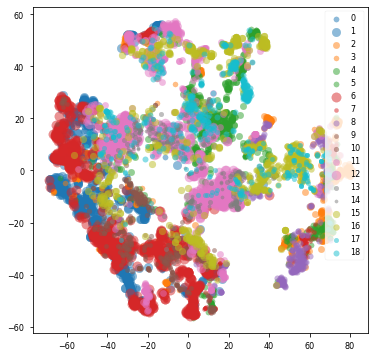

In [21]:
#hidden_plot = pd.read_csv('hidden_plot.csv')
import matplotlib.cm as cm
%matplotlib inline
#colors = cm.rainbow(np.linspace(0, 1, 19))
colors = [plt.cm.tab10(i/float(19-1)) for i in range(19)]

fig = plt.figure(figsize=(6,6))
for label,color in zip(range(19),colors):
    cnt = hidden_plot.loc[hidden_plot['behavior']==label].shape[0]
    plt.scatter(hidden_plot.loc[hidden_plot['behavior']==label,'x'],
               hidden_plot.loc[hidden_plot['behavior']==label,'y'],
               color=color,s=cnt/10,alpha=0.5,label=label)

plt.legend()


plt.show()

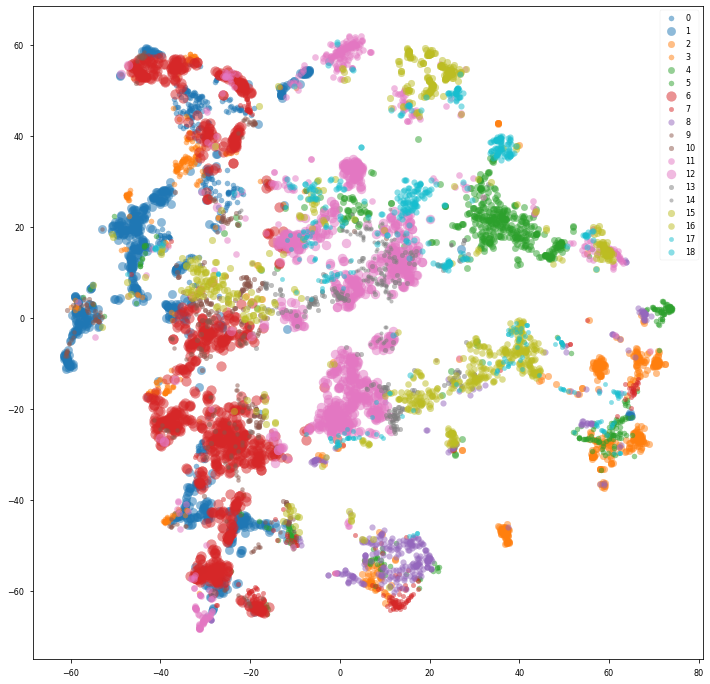

In [87]:
#hidden_plot = pd.read_csv('hidden_plot.csv')
import matplotlib.cm as cm
%matplotlib inline
#colors = cm.rainbow(np.linspace(0, 1, 19))
colors = [plt.cm.tab10(i/float(19-1)) for i in range(19)]

fig = plt.figure(figsize=(12,12))
for label,color in zip(range(19),colors):
    cnt = hidden_plot.loc[hidden_plot['behavior']==label].shape[0]
    plt.scatter(hidden_plot.loc[hidden_plot['behavior']==label,'x'],
               hidden_plot.loc[hidden_plot['behavior']==label,'y'],
               color=color,s=cnt/10,alpha=0.5,label=label)

plt.legend()


plt.show()

In [36]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow as tf
tf.test.is_gpu_available()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10854896457437589800
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 13125887308210126519
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15465449180332086707
physical_device_desc: "device: XLA_GPU device"
]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [81]:
colors={0:'r',1:'g',2:'b',3:'k'}
c=[colors[i] for i in np.round(np.random.uniform(0,3,19),0)]

In [7]:
class TransformerModel(nn.Module):

    def __init__(self, ninp,output_size, nhead=8, nhid=256, nlayers=3, dropout=0.1):
        super(TransformerModel, self).__init__()
        from torch.nn import TransformerEncoder, TransformerEncoderLayer
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(ninp, dropout)
        encoder_layers = TransformerEncoderLayer(ninp, nhead, nhid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.ninp = ninp
        self.fc1 = nn.Linear(ninp*60, 3)
        self.decoder = nn.Linear(3,output_size)
        self.pos_encoder = PositionalEncoding(ninp, dropout)

        self.init_weights()

#     def generate_square_subsequent_mask(self, sz):
#         mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
#         mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
#         return mask

    def init_weights(self):
        initrange = 0.1
        #self.encoder.weight.data.uniform_(-initrange, initrange)
        self.decoder.bias.data.zero_()
        self.decoder.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        #src = self.encoder(src) * math.sqrt(self.ninp)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, None)

        output = output.view(output.size(0),-1)

        fc1_output = self.fc1(output)
        output = self.decoder(fc1_output)
        return output,fc1_output
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=60):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:,:x.size(1), :]
        return self.dropout(x)
    
def evaluate(eval_model, data_source):
    eval_model.eval() # Turn on the evaluation mode
#     total_loss = 0.
#     ntokens = len(TEXT.vocab.stoi)
#     src_mask = model.generate_square_subsequent_mask(bptt).to(device)
    with torch.no_grad():
        output,hidden = eval_model(data_source)
    return output,hidden

In [4]:
x_ = torch.tensor(x).squeeze(-1)
y_ = torch.tensor(y)
x_ = x_.to(device)
y_ = y_.to(device)

In [5]:
# Instantiate the model with hyperparameters
input_size = 10 
output_size = 19
model = TransformerModel(ninp=input_size,output_size=output_size,nhead=2,nhid=256,nlayers=3,dropout=0.1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model.to(device)

# Define hyperparameters
n_epochs = 1000
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

batch_size = 1000
torch.cuda.empty_cache()
for epoch in tqdm(range(1, n_epochs + 1)):
    model.train()
    total_loss = 0.
    for batch, i in enumerate(range(0, x_.size(0) - 1, batch_size)):

        data = x_[i:i+batch_size]
        optimizer.zero_grad() # Clears existing gradients from previous epoch

        output, hidden = model(data.float())
        loss = criterion(output, y_[i:i+batch_size])
        loss.backward() # Does backpropagation and calculates gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step() # Updates the weights accordingly
        total_loss += loss.item()
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(total_loss))

  1%|▊                                                                               | 10/1000 [00:10<17:01,  1.03s/it]

Epoch: 10/1000............. Loss: 22.9633


  2%|█▌                                                                              | 20/1000 [00:20<16:33,  1.01s/it]

Epoch: 20/1000............. Loss: 22.9116


  3%|██▍                                                                             | 30/1000 [00:30<16:25,  1.02s/it]

Epoch: 30/1000............. Loss: 22.8761


  4%|███▏                                                                            | 40/1000 [00:41<16:17,  1.02s/it]

Epoch: 40/1000............. Loss: 21.3048


  5%|████                                                                            | 50/1000 [00:51<16:07,  1.02s/it]

Epoch: 50/1000............. Loss: 18.2152


  6%|████▊                                                                           | 60/1000 [01:01<15:57,  1.02s/it]

Epoch: 60/1000............. Loss: 15.6883


  7%|█████▌                                                                          | 70/1000 [01:11<15:51,  1.02s/it]

Epoch: 70/1000............. Loss: 13.0236


  8%|██████▍                                                                         | 80/1000 [01:21<15:38,  1.02s/it]

Epoch: 80/1000............. Loss: 13.5390


  9%|███████▏                                                                        | 90/1000 [01:32<15:28,  1.02s/it]

Epoch: 90/1000............. Loss: 11.5886


 10%|███████▉                                                                       | 100/1000 [01:42<15:18,  1.02s/it]

Epoch: 100/1000............. Loss: 10.4270


 11%|████████▋                                                                      | 110/1000 [01:52<15:08,  1.02s/it]

Epoch: 110/1000............. Loss: 13.8111


 12%|█████████▍                                                                     | 120/1000 [02:02<14:58,  1.02s/it]

Epoch: 120/1000............. Loss: 9.1071


 13%|██████████▎                                                                    | 130/1000 [02:12<14:48,  1.02s/it]

Epoch: 130/1000............. Loss: 12.6547


 14%|███████████                                                                    | 140/1000 [02:23<14:38,  1.02s/it]

Epoch: 140/1000............. Loss: 9.2352


 15%|███████████▊                                                                   | 150/1000 [02:33<14:28,  1.02s/it]

Epoch: 150/1000............. Loss: 8.4939


 16%|████████████▋                                                                  | 160/1000 [02:43<14:18,  1.02s/it]

Epoch: 160/1000............. Loss: 8.5648


 17%|█████████████▍                                                                 | 170/1000 [02:53<14:07,  1.02s/it]

Epoch: 170/1000............. Loss: 8.4316


 18%|██████████████▏                                                                | 180/1000 [03:03<13:57,  1.02s/it]

Epoch: 180/1000............. Loss: 8.5703


 19%|███████████████                                                                | 190/1000 [03:14<13:47,  1.02s/it]

Epoch: 190/1000............. Loss: 7.2289


 20%|███████████████▊                                                               | 200/1000 [03:24<13:37,  1.02s/it]

Epoch: 200/1000............. Loss: 8.0802


 21%|████████████████▌                                                              | 210/1000 [03:34<13:26,  1.02s/it]

Epoch: 210/1000............. Loss: 6.9553


 22%|█████████████████▍                                                             | 220/1000 [03:44<13:16,  1.02s/it]

Epoch: 220/1000............. Loss: 6.6204


 23%|██████████████████▏                                                            | 230/1000 [03:55<13:07,  1.02s/it]

Epoch: 230/1000............. Loss: 14.2449


 24%|██████████████████▉                                                            | 240/1000 [04:05<12:58,  1.02s/it]

Epoch: 240/1000............. Loss: 9.3568


 25%|███████████████████▊                                                           | 250/1000 [04:15<12:47,  1.02s/it]

Epoch: 250/1000............. Loss: 9.6335


 26%|████████████████████▌                                                          | 260/1000 [04:25<12:36,  1.02s/it]

Epoch: 260/1000............. Loss: 8.0800


 27%|█████████████████████▎                                                         | 270/1000 [04:36<12:25,  1.02s/it]

Epoch: 270/1000............. Loss: 7.6191


 28%|██████████████████████                                                         | 280/1000 [04:46<12:15,  1.02s/it]

Epoch: 280/1000............. Loss: 8.9296


 29%|██████████████████████▉                                                        | 290/1000 [04:56<12:05,  1.02s/it]

Epoch: 290/1000............. Loss: 7.4526


 30%|███████████████████████▋                                                       | 300/1000 [05:06<11:56,  1.02s/it]

Epoch: 300/1000............. Loss: 10.6577


 31%|████████████████████████▍                                                      | 310/1000 [05:16<11:44,  1.02s/it]

Epoch: 310/1000............. Loss: 7.4746


 32%|█████████████████████████▎                                                     | 320/1000 [05:27<11:34,  1.02s/it]

Epoch: 320/1000............. Loss: 9.1319


 33%|██████████████████████████                                                     | 330/1000 [05:37<11:24,  1.02s/it]

Epoch: 330/1000............. Loss: 8.6146


 34%|██████████████████████████▊                                                    | 340/1000 [05:47<11:14,  1.02s/it]

Epoch: 340/1000............. Loss: 8.2097


 35%|███████████████████████████▋                                                   | 350/1000 [05:57<11:04,  1.02s/it]

Epoch: 350/1000............. Loss: 8.4543


 36%|████████████████████████████▍                                                  | 360/1000 [06:07<10:54,  1.02s/it]

Epoch: 360/1000............. Loss: 8.8873


 37%|█████████████████████████████▏                                                 | 370/1000 [06:18<10:43,  1.02s/it]

Epoch: 370/1000............. Loss: 7.9026


 38%|██████████████████████████████                                                 | 380/1000 [06:28<10:33,  1.02s/it]

Epoch: 380/1000............. Loss: 8.0001


 39%|██████████████████████████████▊                                                | 390/1000 [06:38<10:23,  1.02s/it]

Epoch: 390/1000............. Loss: 7.8387


 40%|███████████████████████████████▌                                               | 400/1000 [06:49<10:18,  1.03s/it]

Epoch: 400/1000............. Loss: 7.8348


 41%|████████████████████████████████▍                                              | 410/1000 [06:59<10:03,  1.02s/it]

Epoch: 410/1000............. Loss: 14.5372


 42%|█████████████████████████████████▏                                             | 420/1000 [07:09<09:53,  1.02s/it]

Epoch: 420/1000............. Loss: 7.8600


 43%|█████████████████████████████████▉                                             | 430/1000 [07:19<09:42,  1.02s/it]

Epoch: 430/1000............. Loss: 9.3832


 44%|██████████████████████████████████▊                                            | 440/1000 [07:29<09:32,  1.02s/it]

Epoch: 440/1000............. Loss: 7.1780


 45%|███████████████████████████████████▌                                           | 450/1000 [07:40<09:21,  1.02s/it]

Epoch: 450/1000............. Loss: 7.7637


 46%|████████████████████████████████████▎                                          | 460/1000 [07:50<09:11,  1.02s/it]

Epoch: 460/1000............. Loss: 7.7717


 47%|█████████████████████████████████████▏                                         | 470/1000 [08:00<09:01,  1.02s/it]

Epoch: 470/1000............. Loss: 7.4054


 48%|█████████████████████████████████████▉                                         | 480/1000 [08:10<08:51,  1.02s/it]

Epoch: 480/1000............. Loss: 6.8139


 49%|██████████████████████████████████████▋                                        | 490/1000 [08:21<08:41,  1.02s/it]

Epoch: 490/1000............. Loss: 7.4137


 50%|███████████████████████████████████████▌                                       | 500/1000 [08:31<08:30,  1.02s/it]

Epoch: 500/1000............. Loss: 8.6715


 51%|████████████████████████████████████████▎                                      | 510/1000 [08:41<08:20,  1.02s/it]

Epoch: 510/1000............. Loss: 7.8544


 52%|█████████████████████████████████████████                                      | 520/1000 [08:51<08:10,  1.02s/it]

Epoch: 520/1000............. Loss: 9.9016


 53%|█████████████████████████████████████████▊                                     | 530/1000 [09:01<08:00,  1.02s/it]

Epoch: 530/1000............. Loss: 8.7705


 54%|██████████████████████████████████████████▋                                    | 540/1000 [09:12<07:51,  1.03s/it]

Epoch: 540/1000............. Loss: 7.7917


 55%|███████████████████████████████████████████▍                                   | 550/1000 [09:22<07:40,  1.02s/it]

Epoch: 550/1000............. Loss: 9.7644


 56%|████████████████████████████████████████████▏                                  | 560/1000 [09:32<07:29,  1.02s/it]

Epoch: 560/1000............. Loss: 10.5488


 57%|█████████████████████████████████████████████                                  | 570/1000 [09:42<07:19,  1.02s/it]

Epoch: 570/1000............. Loss: 8.8701


 58%|█████████████████████████████████████████████▊                                 | 580/1000 [09:53<07:09,  1.02s/it]

Epoch: 580/1000............. Loss: 7.8977


 59%|██████████████████████████████████████████████▌                                | 590/1000 [10:03<06:59,  1.02s/it]

Epoch: 590/1000............. Loss: 8.6431


 60%|███████████████████████████████████████████████▍                               | 600/1000 [10:13<06:48,  1.02s/it]

Epoch: 600/1000............. Loss: 7.6263


 61%|████████████████████████████████████████████████▏                              | 610/1000 [10:23<06:38,  1.02s/it]

Epoch: 610/1000............. Loss: 10.2907


 62%|████████████████████████████████████████████████▉                              | 620/1000 [10:33<06:28,  1.02s/it]

Epoch: 620/1000............. Loss: 9.9470


 63%|█████████████████████████████████████████████████▊                             | 630/1000 [10:44<06:18,  1.02s/it]

Epoch: 630/1000............. Loss: 11.4586


 64%|██████████████████████████████████████████████████▌                            | 640/1000 [10:54<06:08,  1.02s/it]

Epoch: 640/1000............. Loss: 9.0491


 65%|███████████████████████████████████████████████████▎                           | 650/1000 [11:04<05:57,  1.02s/it]

Epoch: 650/1000............. Loss: 9.7991


 66%|████████████████████████████████████████████████████▏                          | 660/1000 [11:14<05:47,  1.02s/it]

Epoch: 660/1000............. Loss: 8.3438


 67%|████████████████████████████████████████████████████▉                          | 670/1000 [11:25<05:37,  1.02s/it]

Epoch: 670/1000............. Loss: 8.5873


 68%|█████████████████████████████████████████████████████▋                         | 680/1000 [11:35<05:31,  1.03s/it]

Epoch: 680/1000............. Loss: 7.9012


 69%|██████████████████████████████████████████████████████▌                        | 690/1000 [11:45<05:26,  1.05s/it]

Epoch: 690/1000............. Loss: 9.3843


 70%|███████████████████████████████████████████████████████▎                       | 700/1000 [11:56<05:22,  1.07s/it]

Epoch: 700/1000............. Loss: 11.4816


 71%|████████████████████████████████████████████████████████                       | 710/1000 [12:07<04:58,  1.03s/it]

Epoch: 710/1000............. Loss: 8.8541


 72%|████████████████████████████████████████████████████████▉                      | 720/1000 [12:17<04:51,  1.04s/it]

Epoch: 720/1000............. Loss: 16.0862


 73%|█████████████████████████████████████████████████████████▋                     | 730/1000 [12:27<04:37,  1.03s/it]

Epoch: 730/1000............. Loss: 9.4601


 74%|██████████████████████████████████████████████████████████▍                    | 740/1000 [12:37<04:26,  1.03s/it]

Epoch: 740/1000............. Loss: 13.7630


 75%|███████████████████████████████████████████████████████████▎                   | 750/1000 [12:48<04:15,  1.02s/it]

Epoch: 750/1000............. Loss: 9.8460


 76%|████████████████████████████████████████████████████████████                   | 760/1000 [12:58<04:11,  1.05s/it]

Epoch: 760/1000............. Loss: 11.5931


 77%|████████████████████████████████████████████████████████████▊                  | 770/1000 [13:08<04:00,  1.05s/it]

Epoch: 770/1000............. Loss: 9.3589


 78%|█████████████████████████████████████████████████████████████▌                 | 780/1000 [13:19<03:47,  1.04s/it]

Epoch: 780/1000............. Loss: 8.9406


 79%|██████████████████████████████████████████████████████████████▍                | 790/1000 [13:29<03:40,  1.05s/it]

Epoch: 790/1000............. Loss: 8.2671


 80%|███████████████████████████████████████████████████████████████▏               | 800/1000 [13:40<03:27,  1.04s/it]

Epoch: 800/1000............. Loss: 12.4009


 81%|███████████████████████████████████████████████████████████████▉               | 810/1000 [13:50<03:14,  1.02s/it]

Epoch: 810/1000............. Loss: 8.2272


 82%|████████████████████████████████████████████████████████████████▊              | 820/1000 [14:00<03:03,  1.02s/it]

Epoch: 820/1000............. Loss: 9.5123


 83%|█████████████████████████████████████████████████████████████████▌             | 830/1000 [14:10<02:53,  1.02s/it]

Epoch: 830/1000............. Loss: 41.5673


 84%|██████████████████████████████████████████████████████████████████▎            | 840/1000 [14:21<02:43,  1.02s/it]

Epoch: 840/1000............. Loss: 10.3178


 85%|███████████████████████████████████████████████████████████████████▏           | 850/1000 [14:31<02:34,  1.03s/it]

Epoch: 850/1000............. Loss: 13.0241


 86%|███████████████████████████████████████████████████████████████████▉           | 860/1000 [14:41<02:23,  1.02s/it]

Epoch: 860/1000............. Loss: 19.1517


 87%|████████████████████████████████████████████████████████████████████▋          | 870/1000 [14:51<02:13,  1.03s/it]

Epoch: 870/1000............. Loss: 8.4427


 88%|█████████████████████████████████████████████████████████████████████▌         | 880/1000 [15:02<02:05,  1.04s/it]

Epoch: 880/1000............. Loss: 9.3113


 89%|██████████████████████████████████████████████████████████████████████▎        | 890/1000 [15:12<01:55,  1.05s/it]

Epoch: 890/1000............. Loss: 8.2649


 90%|███████████████████████████████████████████████████████████████████████        | 900/1000 [15:22<01:42,  1.03s/it]

Epoch: 900/1000............. Loss: 9.8152


 91%|███████████████████████████████████████████████████████████████████████▉       | 910/1000 [15:33<01:36,  1.07s/it]

Epoch: 910/1000............. Loss: 8.1257


 92%|████████████████████████████████████████████████████████████████████████▋      | 920/1000 [15:44<01:25,  1.07s/it]

Epoch: 920/1000............. Loss: 7.6221


 93%|█████████████████████████████████████████████████████████████████████████▍     | 930/1000 [15:54<01:12,  1.04s/it]

Epoch: 930/1000............. Loss: 10.5280


 94%|██████████████████████████████████████████████████████████████████████████▎    | 940/1000 [16:05<01:04,  1.07s/it]

Epoch: 940/1000............. Loss: 9.0951


 95%|███████████████████████████████████████████████████████████████████████████    | 950/1000 [16:15<00:51,  1.03s/it]

Epoch: 950/1000............. Loss: 9.2938


 96%|███████████████████████████████████████████████████████████████████████████▊   | 960/1000 [16:25<00:41,  1.05s/it]

Epoch: 960/1000............. Loss: 11.4352


 97%|████████████████████████████████████████████████████████████████████████████▋  | 970/1000 [16:36<00:31,  1.04s/it]

Epoch: 970/1000............. Loss: 8.0148


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 980/1000 [16:46<00:20,  1.05s/it]

Epoch: 980/1000............. Loss: 10.5507


 99%|██████████████████████████████████████████████████████████████████████████████▏| 990/1000 [16:56<00:10,  1.04s/it]

Epoch: 990/1000............. Loss: 7.4733


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [17:07<00:00,  1.03s/it]

Epoch: 1000/1000............. Loss: 7.8090


In [12]:
model.to('cpu').eval() # Turn on the evaluation mode
with torch.no_grad():
    output,hidden = model(x_.float().to('cpu'))

In [13]:
#output,hidden = evaluate(model,x_.float())
hidden_plot = pd.DataFrame(torch.cat([hidden.squeeze(0),output.argmax(1).unsqueeze(1)],dim=1).detach().cpu().numpy(),
            columns=['x','y','z','behavior'])
score = sum(acc_combo(y_true, y_pred) for y_true, y_pred in
            zip(output.argmax(1).detach().cpu().numpy(), y)) / y.shape[0]
print(round(score, 5))

0.11617


In [54]:
x_[:70000].size()

torch.Size([7292, 60, 10])

In [47]:


pe = torch.zeros(60, 10)
position = torch.arange(0, 60, dtype=torch.float).unsqueeze(1)
div_term = torch.exp(torch.arange(0, 10, 2).float() * (-math.log(10000.0) / 60))
pe[:, 0::2] = torch.sin(position * div_term)
pe[:, 1::2] = torch.cos(position * div_term)
pe = pe.unsqueeze(0).transpose(0, 1)

In [49]:
pe.size()

torch.Size([60, 1, 10])

In [38]:
torch.sin(position * div_term).size()

torch.Size([60, 30])

In [43]:
torch.arange(0, 60, dtype=torch.float).unsqueeze(1).size()

torch.Size([60, 1])

In [88]:
import gc

gc.collect()

18007

In [89]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 6            |        cudaMalloc retries: 7         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |  428778 KB |    6139 MB |    2599 GB |    2598 GB |\n|       from large pool |  428409 KB |    6130 MB |    2590 GB |    2589 GB |\n|       from small pool |     369 KB |      28 MB |       9 GB |       9 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |  428778 KB |    6139 MB |    2599 GB |    2598 GB |\n|       from large pool |  428409 KB |    6130 MB |